<a href="https://colab.research.google.com/github/inbalh1/ML/blob/main/DL_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.svm import SVC

import pickle
import os
from google.colab import files
import itertools


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

BATCH_SIZE = 64
TRAIN_SIZE = 5000
TEST_SIZE = 1000
DEFAULT_NUM_OF_EPOCHS = 60

Using cpu device


# Question 1: setup and baseline

### setup

In [2]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True, # set to true for first run - TODO: find elegant solution
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,# set to true for first run - TODO: find elegant solution
    transform=ToTensor(),
)

100%|██████████| 170498071/170498071 [00:01<00:00, 85747526.98it/s] 


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Baseline - svm

In [3]:
# HW part 1 - run svm as baseline

def svm_by_type(kernel , X , y , X_test , y_test):
  clf_SVC = SVC(kernel=kernel , decision_function_shape='ovr')
  clf_SVC.fit(X.reshape([TRAIN_SIZE, 3 * 32 * 32]), y)
  # TODO: should report accuracy (in the doc)
  print("train acc: ", clf_SVC.score(X.reshape([TRAIN_SIZE, 3 * 32 * 32]), y))
  print("test acc: ", clf_SVC.score(X_test.reshape([TEST_SIZE, 3 * 32 * 32]), y_test))
 
# This is the main function for this part 
def svm(train_sampler, test_sampler):
  # We load everything to 1 batch
  train_dataloader = DataLoader(training_data, batch_size=TRAIN_SIZE , sampler = train_sampler , num_workers=2)
  test_dataloader = DataLoader(test_data, batch_size=TEST_SIZE, sampler = test_sampler , num_workers=2)

  X , y = next(iter(train_dataloader))
  X_test , y_test = next(iter(test_dataloader))

  # linear SVM:
  svm_by_type('linear' , X , y , X_test , y_test)

  # rbf kernel SVM
  svm_by_type('rbf' , X , y , X_test , y_test)


# Question 2 - Feed Forward Neural Network

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


def init_weights_wrapper(deviation):
  def init_weights(m):
    if (isinstance(m, nn.Linear)) or (isinstance(m, nn.Conv2d)):
      torch.nn.init.normal_(m.weight , std=deviation)
      #torch.nn.init.normal_(m.bias , std=deviation)
      m.bias.data.fill_(0)
  return init_weights

class GridSearch():
  def __init__(self, file_path, use_history=True):
    self.best_params = {}
    self.best_acc = 0
    self.file_path = file_path
    self.use_history = use_history

  def update_params(self, step_size, momentum, deviation):
    self.best_params['step_size'] = step_size
    self.best_params['momentum'] = momentum
    self.best_params['deviation'] = deviation

  def write_to_file(self, accuracy, loss, time, *args):
    obj = {args: (accuracy, loss, time)}
    with open(self.file_path, "ab") as f:
      pickle.dump(obj, f)

  def get_history(self):
    history_res = {}
    if self.use_history and (os.path.exists(self.file_path)):
      with open(self.file_path, "rb") as f:
        objs = []
        while 1:
            try:
                history_res.update(pickle.load(f))
            except EOFError:
                break
    return history_res

  # Config is a dict of lists that tells the values of the parameters  to run
  def run(self, train_dataloader, test_dataloader, config, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
    import time
    history_res = self.get_history()
    options = itertools.product(config["step_size"], config["momentum"], config["deviation"])
    for step_size, momentum, deviation in options:
      # Don't run if we already know the result
      if self.use_history and ((step_size, momentum, deviation) in history_res):
        accuracy = history_res[(step_size, momentum, deviation)][0]
        if accuracy > self.best_acc:
          self.update_params(step_size, momentum, deviation)
          self.best_acc = accuracy
        continue
      print("Starting gs for ({},{},{})".format(step_size, momentum, deviation))
      start = time.time()
      model = NeuralNetwork().to(device)
      model.apply(init_weights_wrapper(deviation))

      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.SGD(model.parameters(), lr=step_size , momentum=momentum)
      # TODO: should we check train acc or test acc (now we're checking the train)!!!!
      # TODO2 : if we ignore the test(like now) - better not to run it
      train_accuracy, train_loss , __, ___ = train_and_test(train_dataloader, test_dataloader, model,
                                                    loss_fn, optimizer,
                                                    num_of_test_batches=0, num_of_epochs=num_of_epochs, verbose=verbose)
      tot_time = time.time() - start
      accuracy = train_accuracy[-1] # Take last accuracy
      loss = train_loss[-1]
      self.write_to_file(accuracy, loss, tot_time, step_size, momentum, deviation)
      
      if accuracy > self.best_acc:
        self.update_params(step_size, momentum, deviation)
        self.best_acc = accuracy
    return self.best_params

# Train the model for a single epoch
# Returns accuracy and loss
def epoch_train(dataloader, model, loss_fn, optimizer, num_of_batches=-1, verbose=False):
    model.train()

    # Calculate the size of data we run on
    if num_of_batches > 0:
      size = num_of_batches * BATCH_SIZE
    else:
      size = TRAIN_SIZE

    # loss and accuracy of the entire epoch
    epoch_loss, epoch_accuracy  = 0, 0
    for batch, (X, y) in enumerate(dataloader):
      # Dont run more than num_of_batches batches (-1 means to run all)
      if batch == num_of_batches:
        break
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (batch % 100 == 0) and verbose:
          current = (batch + 1) * len(X)
          print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
      epoch_loss += loss.item()
      epoch_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate the total loss and accuracy
    if num_of_batches > 0:
      loss = epoch_loss / num_of_batches
    else:
      loss = epoch_loss / len(dataloader)
    accuracy = epoch_accuracy / size
    return accuracy, loss

def test(dataloader, model, loss_fn, num_of_batches=-1, verbose=False):
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
          # Dont run more than num_of_batches batches (-1 means to run all)
          if batch == num_of_batches:
            break
          X, y = X.to(device), y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate the total loss and accuracy
    if num_of_batches > 0:
      size = num_of_batches * BATCH_SIZE
      test_loss = test_loss / num_of_batches
    else:
      size = TEST_SIZE #len(dataloader.dataset)
      test_loss = test_loss / len(dataloader)
    accuracy = correct / size
    if verbose:
      print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return accuracy, test_loss

# Run train and test for num_of_epochs
# TODO: what should be default for num_of_test_batches?
def train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer,
                   num_of_train_batches=-1, num_of_test_batches=-1, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
    all_loss, all_accuracy, all_test_accuracy, all_test_loss = [], [], [], []
    for i in range(num_of_epochs):
      epoch_accuracy, epoch_loss = epoch_train(train_dataloader, model, loss_fn,
                                             optimizer, num_of_batches=num_of_train_batches, verbose=verbose)
      test_accuracy, test_loss = test(test_dataloader, model, loss_fn, num_of_batches=num_of_test_batches, verbose=verbose)
      all_test_accuracy.append(test_accuracy)
      all_test_loss.append(test_loss)
      all_accuracy.append(epoch_accuracy)
      all_loss.append(epoch_loss)
    return all_accuracy, all_loss, all_test_accuracy, all_test_loss

# Plot train and test accuracy on the same graph,
# and train and test losses on the same graph.
def plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, suptitle):
  epochs = [(x + 1) for x in range(num_of_epochs)]
  fig, axs = plt.subplots(2)
  fig.suptitle(suptitle)
  fig.tight_layout()#pad=3)
  # Plot
  #axs[0].set_title("Accuracy as func of epochs")
  axs[0].plot(epochs, train_accuracy)
  axs[0].plot(epochs, test_accuracy)
  axs[0].set(xlabel='epochs', ylabel='accuracy')
  axs[0].grid()
  axs[0].legend(["train", "test"], loc="best")

  #axs[1].set_title("Loss as func of epochs")
  axs[1].plot(epochs, train_loss)
  axs[1].plot(epochs, test_loss)
  axs[1].set(xlabel='epochs', ylabel='loss')
  axs[1].grid()
  axs[1].legend(["train", "test"], loc="best")

  plt.show()

def pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss):
  # Print the results at the end of optimization
  print(f"Train Error: \n Accuracy: {(100*train_accuracy[-1]):>0.1f}%, Avg loss: {train_loss[-1]:>8f} \n")
  print(f"Test Error: \n Accuracy: {(100*test_accuracy[-1]):>0.1f}%, Avg loss: {test_loss[-1]:>8f} \n")


### Part 2.1.  Baseline

In [5]:
# Part 2.1
# Run the baseline of this part (train and test) and plot the results
# config is a dict of the parameters to run the network with
def run_baseline(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  # Train the network with the best parameters and then test it
  model = NeuralNetwork().to(device)
  model.apply(init_weights_wrapper(config["deviation"]))
  # TODO: can we delete this print?
  for name, param in model.named_parameters():
          print(name , param)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.1 baseline")

  print("Baseline results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)

### Part 2.2. Optimization

In [6]:
# Part 2.2
def change_optimization(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  model = NeuralNetwork().to(device)
  model.apply(init_weights_wrapper(config["deviation"]))

  loss_fn = nn.CrossEntropyLoss()
  # TODO: should we change the momentum (betas) in here?
  optimizer = torch.optim.Adam(model.parameters(), lr=config["step_size"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.2 optimization")
  
  print("Adam optimization results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)

### Part 2.3. Initialization

In [7]:
# Part 2.3

def init_weights_with_xavier(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        #torch.nn.init.xavier_uniform_(m.bias)
        m.bias.data.fill_(0)

def change_initialization(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  model = NeuralNetwork().to(device)
  model.apply(init_weights_with_xavier)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.3 initialization")
  
  print("Xavier initialization results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)

### Part 2.4. Regularization
Add dropout and weight decay to the network

In [8]:
# Part 2.4

class DropoutNeuralNetwork(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 256),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(256, 10)
            #nn.Dropout(dropout)

        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


def regularization(config, train_dataloader, test_dataloader, dropout=0.05, weight_decay=0.1, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  model = DropoutNeuralNetwork(dropout).to(device)
  model.apply(init_weights_wrapper(config["deviation"]))

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"] , weight_decay=weight_decay)
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.4 regularization")

  print("Regularization results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)
  print("Weight decay is: ", weight_decay, " dropout is: ", dropout)

### Part 2.5. Preprocessing
Add PCA whitening

In [9]:
# Part 2.5

from sklearn.decomposition import PCA
#torch.cat([x[0] for x in training_data])

class NeuralNetworkWithPreprocess(nn.Module):
    def __init__(self, pca):
        super().__init__()
        self.pca = pca
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(BATCH_SIZE, 256),
            #nn.Linear(1, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def whitening(self, x):
        x_ = self.flatten(x)
        x_ = self.pca.transform(torch.Tensor.cpu(x_))
        x = (torch.tensor(x_)).to(device).to(torch.float32)
        return x

    def forward(self, x):
        # Apply preprocessing        
        x = self.whitening(x)
        # Apply the network
        logits = self.linear_relu_stack(x)
        return logits


def get_pca(train_sampler):
  train_dataloader = DataLoader(training_data, batch_size=TRAIN_SIZE, sampler=train_sampler)
  pca = PCA(whiten=True, n_components=64) # TODO: not sure about n_comp
  x, y = next(iter(train_dataloader))
  x = x.reshape((TRAIN_SIZE, -1))
  pca.fit(x)
  return pca

def add_preprocessing(config, train_sampler, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  pca = get_pca(train_sampler)
  model = NeuralNetworkWithPreprocess(pca).to(device)
  model.apply(init_weights_wrapper(config["deviation"]))
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.5 preprocessing")

  print("Preprocessing results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)


### Part 2.6. Network width

In [10]:
# Part 2.6

class NeuralNetworkChangingWidth(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, width),
            nn.ReLU(),
            nn.Linear(width, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Create a fig for plotting train and test accuracy and loss
def prepare_fig(suptitle):
  fig, axs = plt.subplots(2)
  fig.suptitle(suptitle)
  fig.tight_layout()#pad=3)
  axs[0].set(xlabel='epochs', ylabel='accuracy')
  axs[0].grid()
  #axs[0].legend(legend, loc="best")
  axs[1].set(xlabel='epochs', ylabel='loss')
  axs[1].grid()
  #axs[1].legend(legend, loc="best")
  return fig, axs  

def plot(axs, num_of_epochs, train_accuracy,
         train_loss, test_accuracy, test_loss):
  # Plot
  epochs = [(x + 1) for x in range(num_of_epochs)]
  axs[0].plot(epochs, train_accuracy)
  axs[0].plot(epochs, test_accuracy)
  axs[1].plot(epochs, train_loss)
  axs[1].plot(epochs, test_loss)
  

def change_width(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  num_of_epochs = 10 # TODO: delete this  line
  fig, axs = prepare_fig("2.6 width")
  # TODO: If we can move  legend a little bit to the side
  legend = []
  for i in [6, 10, 12]:
    width = 2 ** i
    model = NeuralNetworkChangingWidth(width).to(device)
    model.apply(init_weights_wrapper(config["deviation"]))

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
    train_accuracy, train_loss, test_accuracy, test_loss =\
            train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
    plot(axs, num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss)
    legend.append("train width {}".format(width))
    legend.append("test width {}".format(width))

    print("Changing width results, with width", width, ":")
    pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)
  fig.legend(legend, loc="right")
  plt.show()


### Part 2.7. Network Depth

# Question 3 - Convolutional Neural Network

In [11]:
CNNconfig = {
    "step_size": [5e-4, 7e-4,  1e-3, 1e-2],
    "momentum": [0.45, 0.5, 0.55, 0.7, 0.8],
    "deviation": [1, 1.5, 2, 2.25, 2.5,  3]
}

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16*6*6, 784), # TODO: not sure if thats what they wanted
            nn.ReLU(),
            nn.Linear(784, 10)
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



### Part 3.1. Baseline

In [12]:
# Part 3.1

def cnn_run_baseline(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  model = CNN().to(device)
  model.apply(init_weights_wrapper(config["deviation"]))
  # TODO: can we delete this print?
  #for name, param in model.named_parameters():
  #        print(name , param)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "3.1 baseline")

  print("Baseline results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)

# Main
Run all the code of the exercise

In [19]:
# Call all the functions of question 2
def Q2(config, train_dataloader, test_dataloader):
  # Choose which parts to run
  should_run_gs = True
  should_run_baseline = True
  should_run_change_optimization = False
  should_run_change_initialization = False
  should_run_regularization = False
  should_run_preprocessing = False
  should_run_width = False
  
  # Choose best parameters
  #TODO: run grid search with zero biases
  best_config = {}
  if should_run_gs:
    gs = GridSearch("grid_search_q2")
    best_config = gs.run(train_dataloader, test_dataloader, config, verbose=False)
    #best_config["step_size"] = gs.best_params["step_size"]
    #best_config["momentum"] = gs.best_params["momentum"]
    #best_config["deviation"] =  gs.best_params["deviation"]
    files.download('grid_search_q2') # TODO: shuold delete?
    print("Best config is: ")
    print(best_config)
  else:
    best_config["step_size"] = 0.001
    best_config["momentum"] = 0.5
    best_config["deviation"] =  2.5
  

  if should_run_baseline:
    print("Run baseline")
    run_baseline(best_config, train_dataloader, test_dataloader, verbose=False)
    print()
  if should_run_change_optimization:
    print("Run change optimization")
    change_optimization(best_config, train_dataloader, test_dataloader, verbose=False)
    print()
  if should_run_change_initialization:
    print("Run change initialization")
    change_initialization(best_config, train_dataloader, test_dataloader, verbose=False)
    print()
  if should_run_regularization:
    print("Run regularization")
    regularization(best_config, train_dataloader, test_dataloader, num_of_epochs=400, verbose=False)
    print()
  if should_run_preprocessing:
    print("run preprocessing")
    add_preprocessing(best_config, train_sampler, train_dataloader, test_dataloader, verbose=False)
    print()
  if should_run_width:
    print("Run network width")
    change_width(best_config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False)
    print()


In [20]:
# Call all the functions of question 2
def Q3(config, train_dataloader, test_dataloader):
  should_run_gs = True
  should_run_baseline = True
  best_config = {}
  if should_run_gs:
    gs = GridSearch("grid_search_q3")
    best_config = gs.run(train_dataloader, test_dataloader, config, verbose=False)
    #best_config["step_size"] = gs.best_params["step_size"]
    #best_config["momentum"] = gs.best_params["momentum"]
    #best_config["deviation"] =  gs.best_params["deviation"]
    files.download('grid_search_q3')
    print("Best config is: ")
    print(best_config)
  else:
    # The best config is the result of previous run of grid search
    best_config["step_size"] = 0.01
    best_config["momentum"] = 0.8
    best_config["deviation"] =  0.1
  if should_run_baseline:
    print("Run baseline")
    cnn_run_baseline(best_config, train_dataloader, test_dataloader, verbose=False)
    print()


Starting gs for (0.0005,0.2,2.5)
Starting gs for (0.0005,0.5,2.5)
Starting gs for (0.0005,0.8,2.5)
Starting gs for (0.0005,0.9,2.5)
Starting gs for (0.001,0.2,2.5)
Starting gs for (0.001,0.5,2.5)
Starting gs for (0.001,0.8,2.5)
Starting gs for (0.001,0.9,2.5)
Starting gs for (0.01,0.2,2.5)
Starting gs for (0.01,0.5,2.5)
Starting gs for (0.01,0.8,2.5)
Starting gs for (0.01,0.9,2.5)
Starting gs for (0.1,0.2,2.5)
Starting gs for (0.1,0.5,2.5)
Starting gs for (0.1,0.8,2.5)
Starting gs for (0.1,0.9,2.5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Best config is: 
{'step_size': 0.01, 'momentum': 0.8, 'deviation': 0.01}
Run baseline
linear_relu_stack.0.weight Parameter containing:
tensor([[ 0.0042,  0.0149, -0.0127,  ..., -0.0060,  0.0035,  0.0189],
        [ 0.0010,  0.0072, -0.0097,  ...,  0.0104,  0.0088, -0.0170],
        [-0.0170,  0.0025, -0.0013,  ...,  0.0014,  0.0183, -0.0008],
        ...,
        [ 0.0087,  0.0030, -0.0127,  ..., -0.0064, -0.0196,  0.0006],
        [-0.0035, -0.0061,  0.0165,  ..., -0.0056,  0.0043, -0.0249],
        [-0.0050, -0.0163, -0.0062,  ..., -0.0019, -0.0197,  0.0026]],
       requires_grad=True)
linear_relu_stack.0.bias Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0

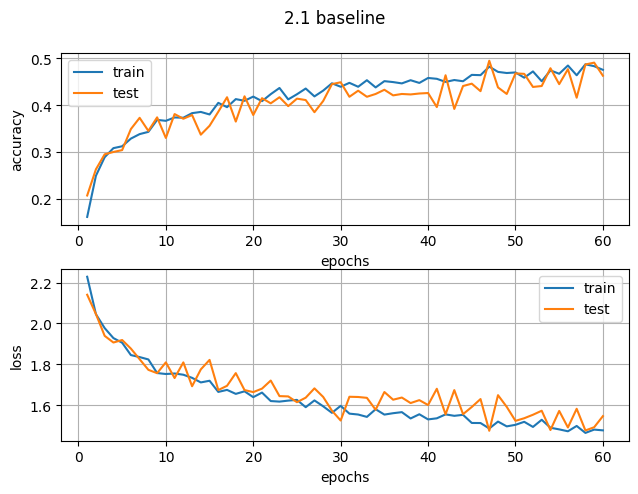

Baseline results: 
Train Error: 
 Accuracy: 47.6%, Avg loss: 1.475987 

Test Error: 
 Accuracy: 46.3%, Avg loss: 1.545596 


Starting gs for (0.0005,0.2,2.5)
Starting gs for (0.0005,0.5,2.5)
Starting gs for (0.0005,0.8,2.5)
Starting gs for (0.0005,0.9,2.5)
Starting gs for (0.001,0.2,2.5)
Starting gs for (0.001,0.5,2.5)
Starting gs for (0.001,0.8,2.5)
Starting gs for (0.001,0.9,2.5)
Starting gs for (0.01,0.2,2.5)
Starting gs for (0.01,0.5,2.5)
Starting gs for (0.01,0.8,2.5)
Starting gs for (0.01,0.9,2.5)
Starting gs for (0.1,0.2,2.5)
Starting gs for (0.1,0.5,2.5)
Starting gs for (0.1,0.8,2.5)
Starting gs for (0.1,0.9,2.5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Best config is: 
{'step_size': 0.01, 'momentum': 0.8, 'deviation': 0.1}
Run baseline


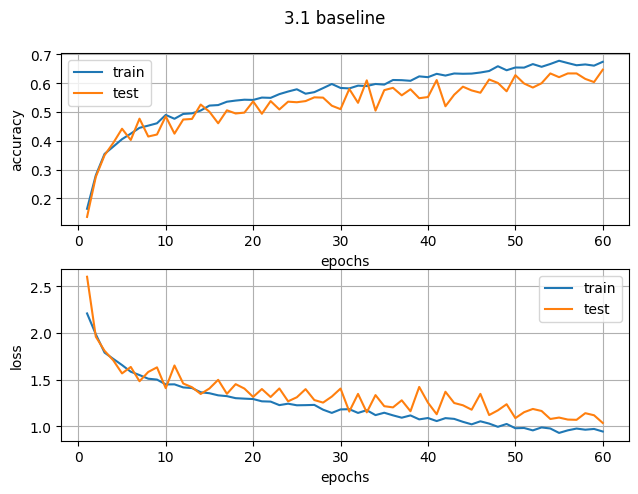

Baseline results: 
Train Error: 
 Accuracy: 67.4%, Avg loss: 0.942488 

Test Error: 
 Accuracy: 64.7%, Avg loss: 1.034254 


end


In [21]:

should_run_svm = False

if __name__ == "__main__":
  # Question 1
  train_sampler = torch.utils.data.RandomSampler(training_data, replacement=True, num_samples=TRAIN_SIZE, generator=None)
  test_sampler = torch.utils.data.RandomSampler(test_data, replacement=True, num_samples=TEST_SIZE, generator=None)

  if should_run_svm:
    svm(train_sampler, test_sampler)

  # Loaders for NN
  num_workers = 1
  train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, sampler=train_sampler , num_workers=num_workers)
  test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, sampler=test_sampler , num_workers=num_workers)

  # TODO: should choose parameters here
  config = {
    "step_size": [5e-4, 1e-3, 1e-2, 1e-1],
    "momentum": [0.2, 0.5, 0.8, 0.9],
    "deviation": [1e-2,1e-1, 1, 2, 2.5]
  }

  Q2(config, train_dataloader, test_dataloader)
  Q3(config, train_dataloader, test_dataloader)

  print("end")

In [17]:
path = 'grid_search_q2'
path = 'grid_search_q3'
#files.download(path)
# Get history from the GS file
#  TODO: should delete this before submition
"""history_res = {}
with open(path, "rb") as f:
  objs = []
  while 1:
      try:
          history_res.update(pickle.load(f))
      except EOFError:
          break
print(len(history_res))
"""

64


In [18]:
history_res

{(0.0005, 0.2, 0.01): (0.2276, 2.1547690675228455, 88.95465397834778),
 (0.0005, 0.2, 0.1): (0.2992, 1.9623065009901794, 89.51448941230774),
 (0.0005, 0.2, 1): (0.247, 44.92620538156244, 89.52320694923401),
 (0.0005, 0.2, 2): (0.2482, 177.29121476185472, 90.36612725257874),
 (0.0005, 0.5, 0.01): (0.269, 2.0666204902190195, 89.72028803825378),
 (0.0005, 0.5, 0.1): (0.3408, 1.8862688465963435, 90.3808581829071),
 (0.0005, 0.5, 1): (0.2562, 30.5501213315167, 89.82803797721863),
 (0.0005, 0.5, 2): (0.2546, 125.93958707399005, 89.93946480751038),
 (0.0005, 0.8, 0.01): (0.3268, 1.8934784584407565, 90.21096706390381),
 (0.0005, 0.8, 0.1): (0.3856, 1.7434512572952463, 89.85004472732544),
 (0.0005, 0.8, 1): (0.254, 8.696901719781417, 90.61035251617432),
 (0.0005, 0.8, 2): (0.2642, 38.556882327115986, 91.02512764930725),
 (0.0005, 0.9, 0.01): (0.366, 1.7872617440887644, 91.70989036560059),
 (0.0005, 0.9, 0.1): (0.4184, 1.662591036361984, 91.01653909683228),
 (0.0005, 0.9, 1): (0.2552, 3.04014797